# Introduction

The goal of this project was to produce win probabilities for any two counterstrike teams. The intention was to compare these probabilities with odds being offered by betting sites and place bets if their odds seem favorable when compared to my model. I went into this with a good deal of skepticism over potential profitability, since I was essentially trying to outperform the bookmakers at their own game. But I figured it would be a good exercise in a real world application of machine learning. 

## Back Story

Initially, I only had about 600 games and their details pulled from the API at www.pandascore.co. I first changed the teams into dummy variables, then trained a model on these dummy variables, with game outcomes as labels. I managed to get some results from this, but figured if I could include more comprehensive stats, that would help a lot. So with a bit of feature engineering, I managed to include statistics like win rate, number of wins, and number of losses up until the game played. This worked out better than just the dummy variables. But I started playing with individual features and trying to find the single best predictive statistic to feed a neural network. Not all features are created equally. The best way to build a model is to start with the best individual features. 

Eventually I scraped the team ratings from www.gosugamers.net and matched this to my game history data. Team ratings are a way of comparing teams in the global league. Teams win points by winning games, and lose points by losing games or being inactive for long enough. The higher the team rating, the better the team. Using team ratings worked out exceptionally well. In fact, suspiciously well... I was worried about how much data leakage was influencing my outcomes. Current ratings were undoubtedly leaking information that hadn't happened yet at the time of the games I was predicting. The dataset I was working with was also quite small, so I was hoping to work with a more extensive set.

This led me to scrape data from each team's history on the same site. Each team has a graph showing how their rating has changed over time, and the games that affected the change. So it was a matter of scraping data from as many of these graphs as possible, then matching up said data to the opponent's information for the same game. This dataset is the result of that scraping.

I have already cleaned the data and dropped any tie games. It's a very simple dataset, but this is meant to serve as an introduction to analyzing individual features and their predictive power. The end goal would likely be to combine a number of these features to further enhance predictive power. But before throwing all possible features at a model for training, it's good to investigate their individual utility. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 1000)

In [2]:
games = pd.read_csv('../input/csgo-ratings/csgo_games_ratings.csv')

# I left the resulting rating changes for each game in the data, but we won't need this.
games.drop(['t1_rating_change', 't2_rating_change'], axis=1, inplace=True)
games.shape

(4789, 7)

In [3]:
games.head(10)

,date,t1,t2,t1_rating,t2_rating,rating_difference,t1_win
0,2014-04-17 00:00:00+02:00,fm!TOXiC,Expert Gaming,1004.0,1000.0,4.0,1
1,2014-06-15 20:00:00+02:00,Lemondogs CS,Expert Gaming,1013.0,970.0,43.0,1
2,2014-06-27 23:30:00+02:00,All-Stars North America,All-Stars Europe,1000.0,1000.0,0.0,1
3,2014-06-30 19:00:00+02:00,UNNAMED.CS,es4x,1000.0,1000.0,0.0,0
4,2014-07-05 19:00:00+02:00,UNNAMED.CS,FaithCS,981.0,882.0,99.0,0
5,2014-07-18 10:00:00+02:00,Outbreak,webSPELL,1000.0,1000.0,0.0,0
6,2014-07-18 14:00:00+02:00,Outbreak,Geduld,980.0,989.0,-9.0,1
7,2014-07-18 14:00:00+02:00,HybriD,Anima,980.0,991.0,-11.0,1
8,2014-07-18 16:00:00+02:00,Outbreak,webSPELL,1001.0,1009.0,-8.0,1
9,2014-07-27 14:00:00+02:00,SVETTiGA,Rasta.B2G,1000.0,999.0,1.0,1


## Initial Hiccups

I started by feeding a deep neural network t1_rating and t2_rating. But the network was picking up on nuance in the data that it shouldn't have. Certain matchups of ratings had very small sample sizes. For example, the network was learning that a matchup of 923 vs 1124 was actually favorable for the 923 rating, since there was only one game of that matchup, and 923 had won.

To remedy this problem, I simplified the input data by reducing t1_rating and t2_rating into one statistic called rating_difference. I speculated that this would capture the important relationship between the two, while forcing our model to stop picking up on patterns between t1_rating and t2_rating that shouldn't be significant.

I assumed the network wouldn't need a lot of neuron's to capture what I imagined as a linear relationship. So I stripped the network down to just one neuron. Since this isn't exactly harnessing the amazing powers of neural networks, I've decided to back up a step and see how some regular machine learning models compare to the ultimately shallow neural network.

## Balancing The Data

Before we get started, we should do a little exploration of the data, and apply some preprocessing. For instance, if there are more t1 wins than losses, we'll want to balance the data so our model isn't influenced by the imbalance.


In [4]:
t1_wins = games[games['t1_win'] == 1]
t2_wins = games[games['t1_win'] == 0]

print('Number of t1 wins: ', len(t1_wins))
print('Number of t2 wins: ', len(t2_wins))

Number of t1 wins:  2372
Number of t2 wins:  2417


While this isn't a huge imbalance, it would likely bias the model somewhat into assuming t2 wins more than t1.

In [5]:
def equalize_wins(games):
    t1_wins = games[games['t1_win'] == 1]
    t2_wins = games[games['t1_win'] == 0]

    min_wins = min(len(t1_wins), len(t2_wins))
    max_wins = max(len(t1_wins), len(t2_wins))

    if len(t2_wins) < len(t1_wins):
        reduced_t1_wins = t1_wins.sample(frac=(min_wins / max_wins), random_state=1)
        games = pd.concat([reduced_t1_wins, t2_wins], axis=0)
    else:
        reduced_t2_wins = t2_wins.sample(frac=(min_wins / max_wins), random_state=1)
        games = pd.concat([reduced_t2_wins, t1_wins], axis=0)

    return games.sample(frac=1, random_state=1)
    
games = equalize_wins(games)

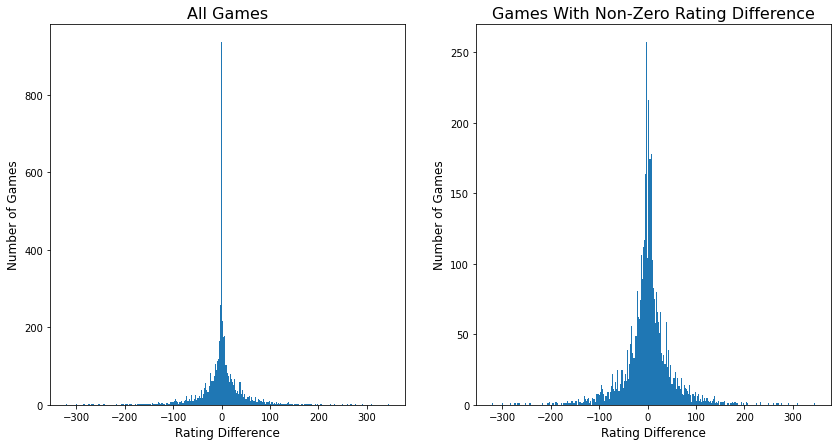

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.hist(games['rating_difference'], bins=300)
ax1.set_ylabel('Number of Games', {'fontsize': 12})
ax1.set_xlabel('Rating Difference', {'fontsize': 12})
ax1.set_title('All Games', {'fontsize': 16})

non_zero = games[games['rating_difference'] != 0]

ax2.hist(non_zero['rating_difference'], bins=300)
ax2.set_ylabel('Number of Games', {'fontsize': 12})
ax2.set_xlabel('Rating Difference', {'fontsize': 12})
ax2.set_title('Games With Non-Zero Rating Difference', {'fontsize': 16})
plt.show()

The distribution of rating_difference seems to be reasonably normal. But we will still normalize our data before feeding it into a network. This should reduce overfitting on the somewhat noisy training set. We may however want to consider dropping games with no rating difference to see how that affects our results.

In [7]:
zero_games = games[games['rating_difference'] == 0]
print('Win rate for zero difference games:', 
      round((zero_games['t1_win'].sum() / len(zero_games)), 4))

Win rate for zero difference games: 0.497


While this isn't the biggest imbalance, including the zero difference games could adversely affect our training, especially since there are so many games with no rating difference. We'll keep this in mind as we explore the expected win rates.

## Expected Win Rates

I expect t1 to win more often than not if t1_rating > t2_rating. But the question is how often? We can get a brief understanding of what kind of model accuracies to expect by looking at the data.

In [8]:
def win_rates(history):
    t1_better_t2 = history[history['rating_difference'] >= 0]
    t1_better_percentage = t1_better_t2['t1_win'].sum() / len(t1_better_t2)

    return round(t1_better_percentage, 4)

non_zero_games = games[games['rating_difference'] != 0].copy()
print('Win rate for all games:', win_rates(games))
print('Win rate for non-zero rating_difference games:', win_rates(non_zero_games))

Win rate for all games: 0.5454
Win rate for non-zero rating_difference games: 0.5653


As expected, the win rate increases if we remove zero difference games from consideration. But even in this case, t1 wins only 56.5% of the time when their rating is better than t2, and conversely loses about 43.5% of the time if their rating is worse than t2. This is far from amazing predictive power. But we would expect that win rate to go up in relation to the difference in rank. 

In [9]:
# Returns a dataframe containing the win rates for games with a greater absolute rating_difference than i, along with the number of games in the sample
def win_rate(games):
    rating_win_rate = []
    games['rating_difference'] = games['rating_difference'].astype(int)
    for i in range(0, games['rating_difference'].abs().max()):
        t1_better_t2 = games[games['rating_difference'] > i]
        t1_worse_t2 = games[games['rating_difference'] < -i]

        # We are interested in the t1_worse_t2 games where t1_win is 0, this is captured below.
        wins = t1_better_t2['t1_win'].sum() + (len(t1_worse_t2) - t1_worse_t2['t1_win'].sum())
        num_games = len(t1_better_t2) + len(t1_worse_t2)
        win_rate = wins / num_games

        rating_win_rate.append({'rating_difference': i, 
                                'win_rate': win_rate, 
                                'num_games': num_games})

    return pd.DataFrame(rating_win_rate)

In [10]:
def plot_win_rating(games):
    fig, ax1 = plt.subplots(figsize=(7, 7))
    ax1.set_title('Win Rate vs Rating Difference', {'fontsize': 16})

    ax1.bar(x=games['rating_difference'], 
            height=games['num_games'], 
            width=2,
            alpha=0.4)
    ax1.set_xlabel('Rating difference', {'fontsize': 12})
    ax1.set_ylabel('Number of Games', {'fontsize': 12})

    ax2 = fig.add_subplot(sharex=ax1, frameon=False)
    ax2.plot(games['win_rate'], color='r')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right')
    ax2.set_ylabel('Win Rate', {'fontsize': 12})

    plt.show()

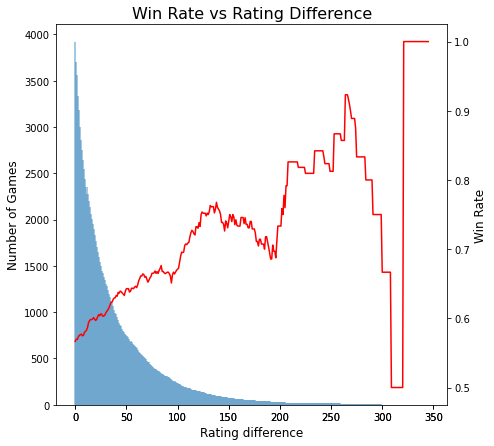

In [11]:
rating_win_rate = win_rate(games)
plot_win_rating(rating_win_rate)

This graph shows how often t1 or t2 wins if their rating difference is greater than x. We can see that initially, the win rate increases linearly in relation to the difference in rating. But this relationship deteriorates as the sample of games decreases. It may be worth playing around with the dataset and dropping games with a rating difference too large to have a significant sample size. 

# Applying Machine Learning

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale

from scipy import stats

import tensorflow as tf
from tensorflow import keras

results = []

## Decision Tree Classifier

In [13]:
def decision_tree_classifier(games):
    x = np.array(games['rating_difference']).reshape(-1, 1)
    y = games['t1_win']

    x = scale(x)

    hyperparameters = {
        'max_depth': [2, 3, 4, 5],
        'min_samples_split': [2, 3, 4, 5],
        'min_samples_leaf': [1, 2, 3, 4, 5],
        'max_leaf_nodes': [5, 6, 7, 8, 9]

    }
    dtc = DecisionTreeClassifier()
    grid = GridSearchCV(dtc, param_grid=hyperparameters, cv=5)
    grid.fit(x, y)

    return grid.best_params_, grid.best_score_
  
include_zero = decision_tree_classifier(games)
non_zero = decision_tree_classifier(non_zero_games)
print('With zero rating difference \nBest accuracy: ', round(include_zero[1], 4), 
      '\nBest parameters: ', include_zero[0])
print('\nWithout zero rating difference \nBest accuracy: ', round(non_zero[1], 4), 
      '\nBest parameters: ', non_zero[0])

results.append({'model': 'Decision Tree', 
                'non_zero': round(non_zero[1], 4), 
                'include_zero': round(include_zero[1], 4)}
              )

With zero rating difference 
Best accuracy:  0.5502 
Best parameters:  {'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Without zero rating difference 
Best accuracy:  0.5602 
Best parameters:  {'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


As we expected, excluding games with zero rating difference does increase the accuracy of our model. 

Even just using a decision tree classifier, we're able to get very close to the accuracy we expected from earlier (56.02% vs 56.53%). 

More surprisingly, the model we ran including games with zero rating difference actually performed marginally better than the win rate we saw earlier (55.02% vs 54.54%).

## K Nearest Neighbors

In [14]:
def k_nearest_neighbors(games):    
    x = np.array(games['rating_difference']).reshape(-1, 1)
    y = games['t1_win']

    x = scale(x)

    hyperparameters = {
        'n_neighbors': [10, 20, 30, 40, 50, 60, 70],
        'weights': ['uniform', 'distance'],
        'algorithm': ['brute', 'auto'],
        'p': [1, 2]

    }
    knc = KNeighborsClassifier()
    grid = GridSearchCV(knc, param_grid=hyperparameters, cv=5)
    grid.fit(x, y)

    return grid.best_params_, grid.best_score_
    
include_zero = k_nearest_neighbors(games)
non_zero = k_nearest_neighbors(non_zero_games)
print('With zero rating difference \nBest accuracy: ', round(include_zero[1], 4), 
      '\nBest parameters: ', include_zero[0])
print('\nWithout zero rating difference \nBest accuracy: ', round(non_zero[1], 4), 
      '\nBest parameters: ', non_zero[0])

results.append({'model': 'K Neighbors', 
                'non_zero': round(non_zero[1], 4), 
                'include_zero': round(include_zero[1], 4)}
              )

With zero rating difference 
Best accuracy:  0.5464 
Best parameters:  {'algorithm': 'brute', 'n_neighbors': 70, 'p': 2, 'weights': 'uniform'}

Without zero rating difference 
Best accuracy:  0.5553 
Best parameters:  {'algorithm': 'brute', 'n_neighbors': 50, 'p': 2, 'weights': 'uniform'}


Not quite as good as the decision tree classifier. 

## Random Forest Classifier

In [15]:
def random_forest_classifier(games):    
    x = np.array(games['rating_difference']).reshape(-1, 1)
    y = games['t1_win']

    x = scale(x)

    hyperparameters = {
        'n_estimators': [10, 15, 20, 25],
        'max_depth': [2, 3, 4],
        'min_samples_split': [5, 10, 15, 20],
        'max_leaf_nodes': [20, 25, 30, 35],
        'random_state': [1]

    }
    rfc = RandomForestClassifier()
    grid = GridSearchCV(rfc, param_grid=hyperparameters, cv=5)
    grid.fit(x, y)

    return grid.best_params_, grid.best_score_
    
include_zero = random_forest_classifier(games)
non_zero = random_forest_classifier(non_zero_games)
print('With zero rating difference \nBest accuracy: ', round(include_zero[1], 4), 
      '\nBest parameters: ', include_zero[0])
print('\nWithout zero rating difference \nBest accuracy: ', round(non_zero[1], 4), 
      '\nBest parameters: ', non_zero[0])

results.append({'model': 'Random Forest', 
                'non_zero': round(non_zero[1], 4), 
                'include_zero': round(include_zero[1], 4)}
              )

With zero rating difference 
Best accuracy:  0.5561 
Best parameters:  {'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_split': 5, 'n_estimators': 10, 'random_state': 1}

Without zero rating difference 
Best accuracy:  0.5686 
Best parameters:  {'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_split': 20, 'n_estimators': 10, 'random_state': 1}


We have a new winner! 56.86%!

## C-Support Vector Classification

In [16]:
def cvc(games):
    x = np.array(games['rating_difference']).reshape(-1, 1)
    y = games['t1_win']

    x = scale(x)

    hyperparameters = {}

    svc = SVC()
    grid = GridSearchCV(svc, param_grid=hyperparameters, cv=10)
    grid.fit(x, y)

    return grid.best_params_, grid.best_score_
    
include_zero = cvc(games)
non_zero = cvc(non_zero_games)
print('With zero rating difference \nBest accuracy: ', round(include_zero[1], 4))
print('\nWithout zero rating difference \nBest accuracy: ', round(non_zero[1], 4))

results.append({'model': 'CVC', 
                'non_zero': round(non_zero[1], 4), 
                'include_zero': round(include_zero[1], 4)}
              )

With zero rating difference 
Best accuracy:  0.5506

Without zero rating difference 
Best accuracy:  0.5597


Nothing to write home about here.

## Stochastic Gradient Descent

In [17]:
def sgd(games):
    x = np.array(games['rating_difference']).reshape(-1, 1)
    y = games['t1_win']

    x = scale(x)

    hyperparameters = {
        'loss': ['log', 'hinge', 'squared_loss'],
        'max_iter': [10000],
        'shuffle': [False]
    }
    sgdc = SGDClassifier()
    grid = GridSearchCV(sgdc, param_grid=hyperparameters, cv=10)
    grid.fit(x, y)

    return grid.best_params_, grid.best_score_
    
include_zero = sgd(games)
non_zero = sgd(non_zero_games)

print('With zero rating difference \nBest accuracy: ', round(include_zero[1], 4), 
      '\nBest parameters: ', include_zero[0])
print('\nWithout zero rating difference \nBest accuracy: ', round(non_zero[1], 4), 
      '\nBest parameters: ', non_zero[0])

results.append({'model': 'SGD', 
                'non_zero': round(non_zero[1], 4), 
                'include_zero': round(include_zero[1], 4)}
              )

With zero rating difference 
Best accuracy:  0.5474 
Best parameters:  {'loss': 'log', 'max_iter': 10000, 'shuffle': False}

Without zero rating difference 
Best accuracy:  0.5604 
Best parameters:  {'loss': 'hinge', 'max_iter': 10000, 'shuffle': False}


Not bad, but not great!

## Results of Regular Machine Learning

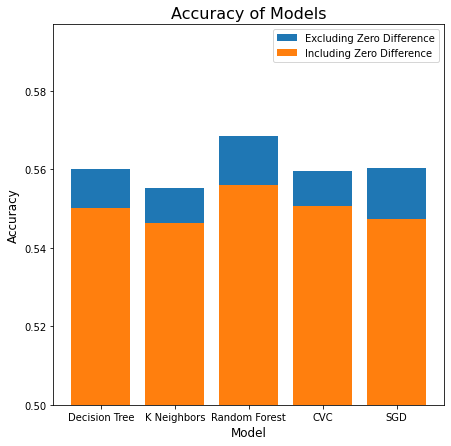

In [18]:
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(7, 7))

ax.bar(x=results_df['model'], 
       height=results_df['non_zero'], 
       label='Excluding Zero Difference')
ax.bar(x=results_df['model'], 
       height=results_df['include_zero'], 
       label='Including Zero Difference')

ax.set_ylim(bottom=0.5)
ax.set_title('Accuracy of Models', {'fontsize':16})
ax.set_ylabel('Accuracy', {'fontsize':12})
ax.set_xlabel('Model', {'fontsize':12})
ax.legend(loc='upper right')

plt.show()

As far as regular machine learning goes, the random forest classifier produced the best results with an accuracy of 56.86%.

## "Neural Network"

Now for the big guns! The world's smallest neural network!

In [19]:
def create_model():

    model = keras.Sequential()
    model.add(keras.layers.Dense(2, activation="softmax"))

    opt = tf.keras.optimizers.Adam()

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

# Don't turn x into an nparray yet, 
# so we can track the non scaled values during the shuffle to keep comparisons intuitive.
x = non_zero_games['rating_difference']
non_zero_games['scaled_x'] = scale(x)
y = np.array(non_zero_games['t1_win'])

train_x, test_x, train_y, test_y = train_test_split(non_zero_games[['rating_difference', 
                                                                    'scaled_x']], 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=1, 
                                                    shuffle=True
                                                   )

model = create_model()
model.fit(np.array(train_x['scaled_x']), 
          train_y, 
          validation_data=(np.array(test_x['scaled_x']), 
          test_y), 
          epochs=100, 
          verbose=2
         )

Train on 3130 samples, validate on 783 samples
Epoch 1/100
3130/3130 - 1s - loss: 0.7381 - accuracy: 0.4329 - val_loss: 0.7233 - val_accuracy: 0.4278
Epoch 2/100
3130/3130 - 0s - loss: 0.7154 - accuracy: 0.4342 - val_loss: 0.7060 - val_accuracy: 0.4317
Epoch 3/100
3130/3130 - 0s - loss: 0.7006 - accuracy: 0.4435 - val_loss: 0.6954 - val_accuracy: 0.4559
Epoch 4/100
3130/3130 - 0s - loss: 0.6918 - accuracy: 0.5153 - val_loss: 0.6892 - val_accuracy: 0.5517
Epoch 5/100
3130/3130 - 0s - loss: 0.6868 - accuracy: 0.5502 - val_loss: 0.6865 - val_accuracy: 0.5517
Epoch 6/100
3130/3130 - 0s - loss: 0.6839 - accuracy: 0.5585 - val_loss: 0.6850 - val_accuracy: 0.5568
Epoch 7/100
3130/3130 - 0s - loss: 0.6824 - accuracy: 0.5607 - val_loss: 0.6845 - val_accuracy: 0.5568
Epoch 8/100
3130/3130 - 0s - loss: 0.6817 - accuracy: 0.5620 - val_loss: 0.6842 - val_accuracy: 0.5670
Epoch 9/100
3130/3130 - 0s - loss: 0.6813 - accuracy: 0.5607 - val_loss: 0.6842 - val_accuracy: 0.5670
Epoch 10/100
3130/3130 - 0

Since the model is only one neuron, the model should be creating a simple linear relationship between rating_difference and t1_win. We can see this is the case by looking at the graph of t1_confidence.

In [20]:
# This function matches the nparrays we fed into our model with their dataframe counterparts 
def prob_details(x, y):    
    probabilities = model.predict(np.array(x['scaled_x']))
    with_ratings = pd.concat([pd.DataFrame(probabilities, 
                                           columns=['t2_confidence', 't1_confidence']),
                              x['rating_difference'].reset_index(drop=True),
                              pd.DataFrame(y, columns=['t1_win'])], 
                             axis=1
                            )
    return with_ratings

[]

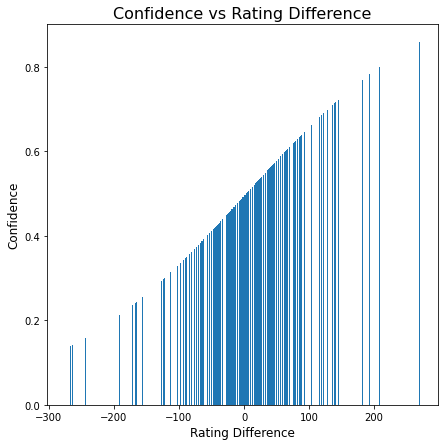

In [21]:
test_details = prob_details(test_x, test_y)

fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.set_title('Confidence vs Rating Difference', {'fontsize': 16})
ax1.bar(test_details['rating_difference'], test_details['t1_confidence'])
ax1.set_xlabel('Rating Difference', {'fontsize': 12})
ax1.set_ylabel('Confidence', {'fontsize': 12})

plt.plot()

This gives us a pretty intuitive understanding of the linear relationship the model comes up with between confidence and the rating difference. 

Now let's see how the model's confidence compares to the actual win rates of the data.

In [22]:
def plot_confidence_win_rate(games):
    plt.figure(figsize=(7, 7))
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(games['rating_difference'], 
                                                             games['t1_confidence'], 
                                                             'mean', 
                                                             bins=10)
    plt.hlines(bin_means, 
               bin_edges[:-1], 
               bin_edges[1:], 
               colors='r', 
               alpha=0.8, 
               label='Average Confidence')
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(games['rating_difference'], 
                                                             games['t1_win'], 
                                                             'mean', 
                                                             bins=10)
    plt.hlines(bin_means, 
               bin_edges[:-1], 
               bin_edges[1:], 
               colors='b', 
               alpha=0.8, 
               label='Average Win Rate')
    
    plt.legend(loc='upper left')
    plt.title('Win Rates and Model Confidence', {'fontsize':16})
    plt.ylabel('Confidence / Win Rate', {'fontsize':12})
    plt.xlabel('Rating Difference', {'fontsize':12})
    plt.show()

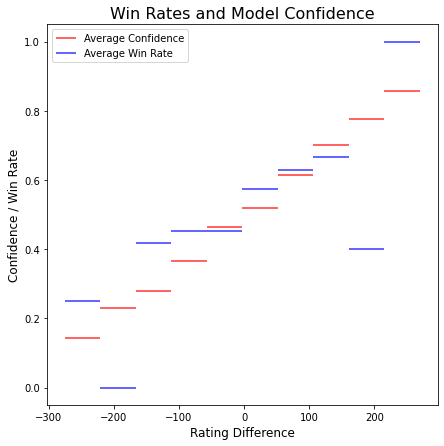

In [23]:
plot_confidence_win_rate(test_details)

There does seem to be at least a loose relationship between the model's confidence rates and the actual win rates of those games.

The relationship may make more sense if we compare predictions on the training data to the actual win rate. Normally this wouldn't be advised, since overfitting can make any model seem smarter than it is. However, the accuracy and loss between the training set and the test set are reasonably similar. Also, since there is only one neuron, the model doesn't really have the complexity to overfit on the training data. This all suggests that overfitting is relatively insubstantial, and we can look at our performance on the training set with a pinch of salt.

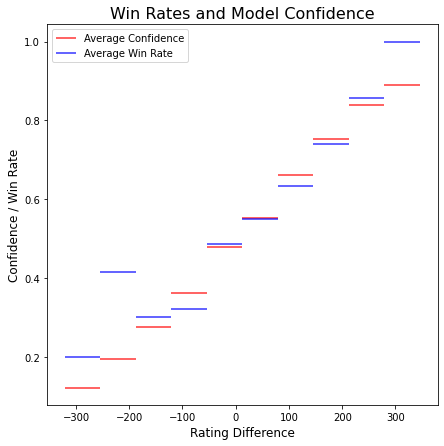

In [24]:
train_details = prob_details(train_x, train_y)
plot_confidence_win_rate(train_details)

Looks pretty reasonable.

It should however be noted that the edge cases have fewer games in their respective sample sizes. We saw earlier how the linear relationship between the rating difference and the win rate deteriorated as the absolute rating difference increased. So we should put more stock into the middle section of these graphs, because the majority of the data exists in the portion between -100 and 100.

# Conclusion

This was meant to be a small introduction to the process and potential of applying machine learning to new applications. It is by no means enough to start bookmaking for CS:GO games on it's own. But by adding more proven features, you could build a model robust enough to profitably make books with a large enough vig.

Other interesting ideas to explore:

* Scraping more intricate team statistics and adding these to the model. 
* Adding historical betting odds to the model (This would be enormously helpful if you could find a good dataset).
* Cutting out extreme rating differences from consideration.

I'll keep working on this notebook for the next little while. I would like to upgrade most of the graphs and explore more ways of presenting relationships in the data. I'm also still curious about the effectiveness of removing extreme rating differences from consideration. 

Thanks for taking a look at my notebook!